### Background	
1. The Customer Data tab contains the data for your assignment	
2. The data is at a customer level (doctor data) and contains the following information: 	
    * Customer Demographic information
    * Promotional activity targeted at the customer (emails, calls, faxes). 
    * Calls refers to the tele-marketing calls made to doctors (columns H and I); Emails refers to promotional emails (columns J & K) and Faxes refers to promotional material faxed to doctors (col L)
    * Sales data by the customer (Brand 1, Brand 2, Branded Market and Total Market)

3. Brand 1 is pharma Company's brand for which promotional activity has been performed	
4. Brand 2 is a key competitor of Brand 1	
5. Total Branded Market contains sales of Brand 1, Brand 2 and some other brands	
6. Total Market (Branded + Unbranded) Sales contains sales of Total Branded Market and Unbranded Market products	
	
### Business Problem	
1. Using Exploratory Data Analysis, show your understanding of the Brand and Market situation	
2. Build a predictive model that estimates the impact of each channel (i.e. Calls, Emails, Faxes) on Brand 1 sales, for different customer segments based on total market sales(Column P)	
3. Consider columns C to M for building predictive model, considering column M as your target variable	

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.tools as sm
from statsmodels.regression.linear_model import OLS

sns.set_palette("husl", 9)

import warnings
warnings.filterwarnings('ignore')

In [105]:
rd = pd.read_csv('../data/prescription_prediction.csv',sep='\t'); rd.head()

,Customer ID,Title,Specialty Code,Specialty Description,State,Region,Call Attempts,Calls Successfully Completed,Emails Sent,Emails Opened,Faxes Sent,Brand 1 Sales (Company's Brand),Brand 2 Sales (Competitor Brand),Total Branded Market Sales,Total Market (Branded + Unbranded) Sales
0,IND000001,MD,FM,FAMILY MEDICINE,SC,South Region,1,0,13,6,8,8.0,NaN,27,131
1,IND000002,MD,CD,CARDIOVASCULAR DISEASES,SC,South Region,1,0,15,8,6,3.0,NaN,40,56
2,IND000003,MD,IM,INTERNAL MEDICINE,AL,South Region,2,1,4,2,6,7.0,NaN,27,161
3,IND000004,MD,FM,FAMILY MEDICINE,AL,South Region,0,0,11,9,8,9.0,NaN,39,180
4,IND000005,MD,CD,CARDIOVASCULAR DISEASES,AL,South Region,5,5,0,0,9,4.0,NaN,14,44


In [106]:
rd.shape

(77641, 15)

In [107]:
rd.tail()

,Customer ID,Title,Specialty Code,Specialty Description,State,Region,Call Attempts,Calls Successfully Completed,Emails Sent,Emails Opened,Faxes Sent,Brand 1 Sales (Company's Brand),Brand 2 Sales (Competitor Brand),Total Branded Market Sales,Total Market (Branded + Unbranded) Sales
77636,IND077637,PAC,UNK,UNKNOWN,PA,Northeast Region,0,0,14,11,7,5.0,5.0,15,94
77637,IND077638,MS,UNK,UNKNOWN,NY,Northeast Region,0,0,1,0,4,1.0,0.0,13,43
77638,IND077639,MSN,UNK,UNKNOWN,CA,West Region,5,2,8,5,1,4.0,NaN,27,4
77639,IND077640,NP,UNK,UNKNOWN,TX,South Region,3,3,20,16,6,6.0,NaN,26,61
77640,IND077641,PA,UNK,UNKNOWN,NY,Northeast Region,0,0,8,7,4,5.0,NaN,44,93


## Preliminary EDA

In [108]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77641 entries, 0 to 77640
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Customer ID                               77641 non-null  object 
 1   Title                                     77641 non-null  object 
 2   Specialty Code                            77641 non-null  object 
 3   Specialty Description                     77641 non-null  object 
 4   State                                     77641 non-null  object 
 5   Region                                    76280 non-null  object 
 6   Call Attempts                             77641 non-null  int64  
 7   Calls Successfully Completed              77641 non-null  int64  
 8   Emails Sent                               77641 non-null  int64  
 9   Emails Opened                             77641 non-null  int64  
 10  Faxes Sent                        

In [109]:
print(rd['Region'].isnull().sum()*100/77641)
print(rd["Brand 1 Sales (Company's Brand)"].isnull().sum()*100/77641)
print(rd['Brand 2 Sales (Competitor Brand)'].isnull().sum()*100/77641)

1.7529398127278113
0.06697492304323746
56.40705297458817


In [110]:
rd[rd.duplicated()]

,Customer ID,Title,Specialty Code,Specialty Description,State,Region,Call Attempts,Calls Successfully Completed,Emails Sent,Emails Opened,Faxes Sent,Brand 1 Sales (Company's Brand),Brand 2 Sales (Competitor Brand),Total Branded Market Sales,Total Market (Branded + Unbranded) Sales


In [111]:
rd.columns = ['cust_id', 'title', 'spec_code', 'spec_desc','st', 'reg', 'atmptd_calls', 'calls_cmpltd','emails_snt', 'emails_opnd', 'faxes_snt','brnd_sls', 'comp_sls','tot_brnded_sls','tot_mkt_sls']

In [112]:
rd.head(1)

,cust_id,title,spec_code,spec_desc,st,reg,atmptd_calls,calls_cmpltd,emails_snt,emails_opnd,faxes_snt,brnd_sls,comp_sls,tot_brnded_sls,tot_mkt_sls
0,IND000001,MD,FM,FAMILY MEDICINE,SC,South Region,1,0,13,6,8,8.0,NaN,27,131


In [113]:
# check if calls completed are greater than attempted calls
rd[np.where(rd['calls_cmpltd']>rd['atmptd_calls'],True,False)] 

,cust_id,title,spec_code,spec_desc,st,reg,atmptd_calls,calls_cmpltd,emails_snt,emails_opnd,faxes_snt,brnd_sls,comp_sls,tot_brnded_sls,tot_mkt_sls


In [114]:
# check if emails opened are greater than emails sent, this is with the assumption that if same email is opened multiple times it would treated as one open
rd[np.where(rd['emails_opnd']>rd['emails_snt'],True,False)] 

,cust_id,title,spec_code,spec_desc,st,reg,atmptd_calls,calls_cmpltd,emails_snt,emails_opnd,faxes_snt,brnd_sls,comp_sls,tot_brnded_sls,tot_mkt_sls


In [115]:
# check if brand sales is greater than total branded sales
rd[np.where(rd['brnd_sls']>rd['tot_brnded_sls'],True,False)] 

,cust_id,title,spec_code,spec_desc,st,reg,atmptd_calls,calls_cmpltd,emails_snt,emails_opnd,faxes_snt,brnd_sls,comp_sls,tot_brnded_sls,tot_mkt_sls


In [116]:
# check if total branded sales is greater than total market sales which includes both branded and unbranded sales
print(rd[np.where(rd['tot_brnded_sls']>rd['tot_mkt_sls'],True,False)].shape[0]*100/77641)

29.900439200937647


## Detailed EDA

In [117]:
rd_cat = rd[[ 'title', 'spec_code', 'spec_desc','st', 'reg']]

In [118]:
rd_cont = rd[['atmptd_calls', 'calls_cmpltd','emails_snt', 'emails_opnd', 'faxes_snt','brnd_sls', 'comp_sls','tot_brnded_sls','tot_mkt_sls']]

In [119]:
for col in rd_cat.columns: 
    print('{} has {} unique values. The count for each value is as below.'.format(col,rd_cat[col].nunique()))
    print(rd_cat[col].value_counts(),'\n\n')

title has 56 unique values. The count for each value is as below.
MD     58798
DO      9014
NP      2792
PA      2142
PAC     1371
FNP     1151
APR      751
MSN      469
NPC      138
CRN      130
APN      123
CNP      118
ANP      117
ARN      113
DNP       72
RPA       60
MPA       56
MS        38
CFN       25
BC        21
MSP       19
MMS       14
MN         7
PHD        7
GNP        6
NUR        6
DDS        6
DPM        5
AGN        5
RN         5
NPF        4
CNS        4
DVM        4
BS         4
MPH        4
OD         4
PHA        3
NPB        3
CNM        3
RNP        3
AGA        3
ND         3
DMD        2
AGP        2
PC         2
BCF        2
NMD        2
PRA        2
MNF        1
BSM        1
PAN        1
RNB        1
PMH        1
MBA        1
CS         1
VMD        1
Name: title, dtype: int64 


spec_code has 139 unique values. The count for each value is as below.
FM     28502
IM     21892
UNK    11523
CD      5794
END     1977
       ...  
CRS        1
PPN        1
PD

In [120]:
rd_cont.skew()

atmptd_calls       0.001477
calls_cmpltd       0.762738
emails_snt         0.003836
emails_opnd        0.554297
faxes_snt         -0.004659
brnd_sls           6.007734
comp_sls          31.526980
tot_brnded_sls     0.310270
tot_mkt_sls        5.022796
dtype: float64

Normality test for atmptd_calls
Statitics = 0.906, p value = 0.000


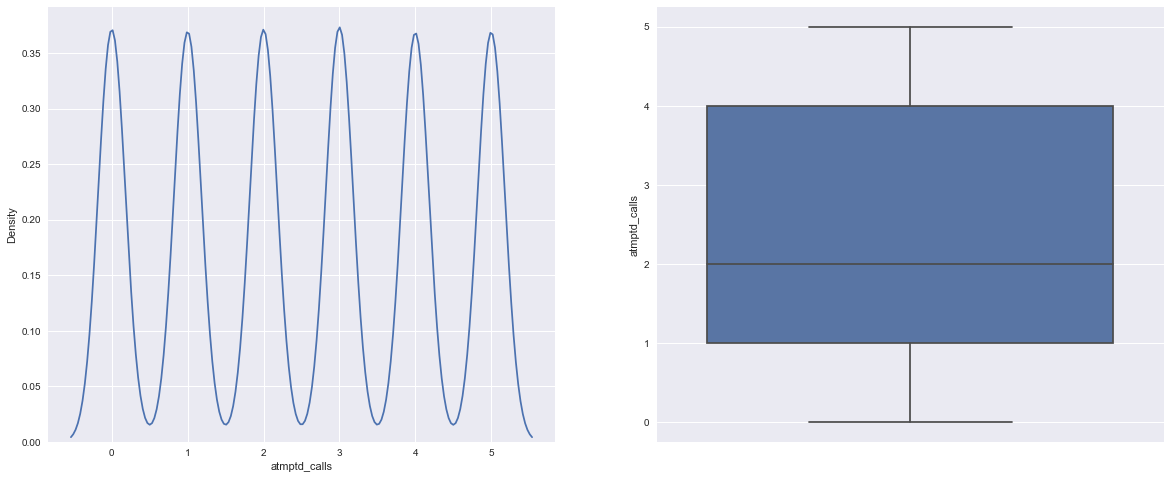

atmptd_calls is not normally distributed.

Normality test for calls_cmpltd
Statitics = 0.833, p value = 0.000


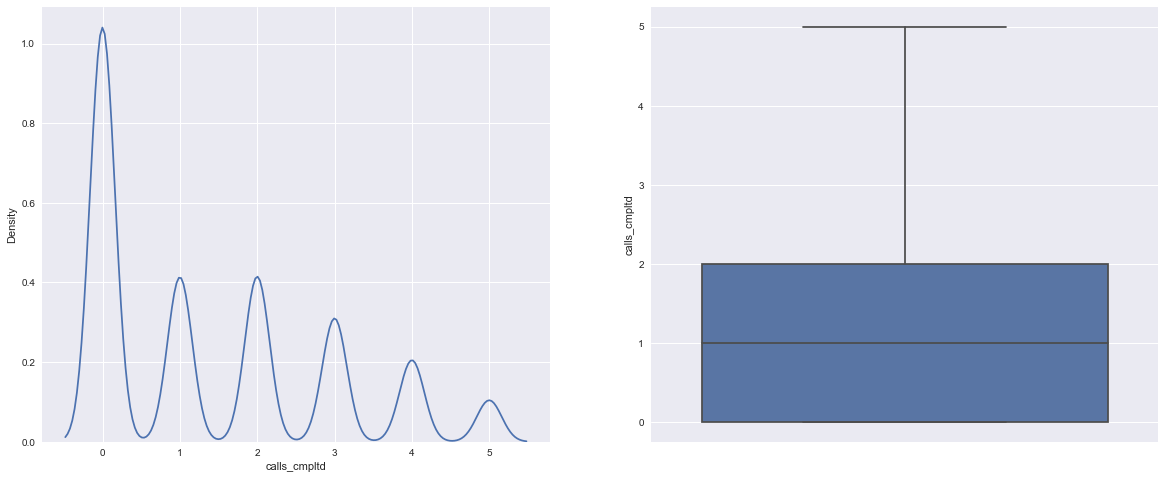

calls_cmpltd is not normally distributed.

Normality test for emails_snt
Statitics = 0.951, p value = 0.000


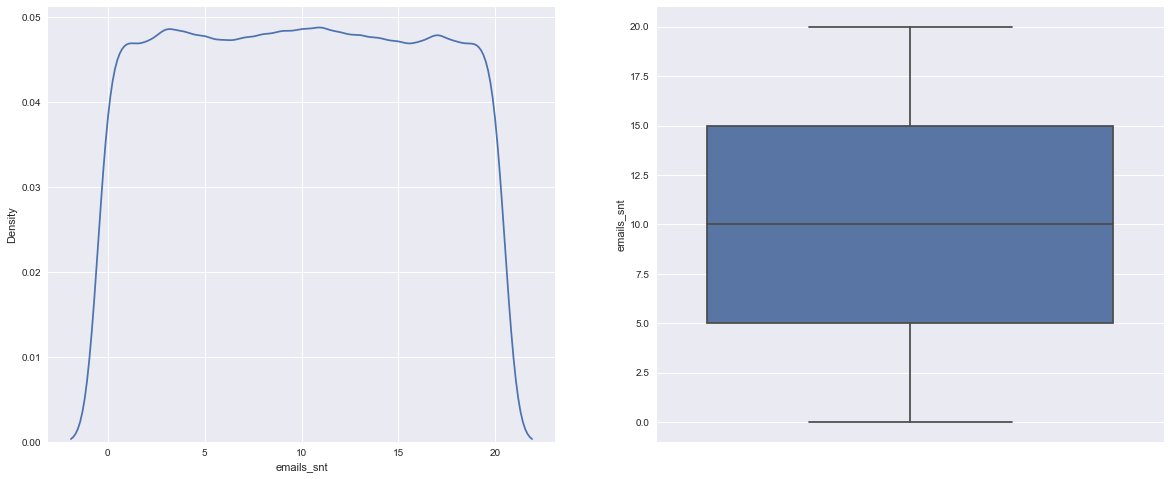

emails_snt is not normally distributed.

Normality test for emails_opnd
Statitics = 0.894, p value = 0.000


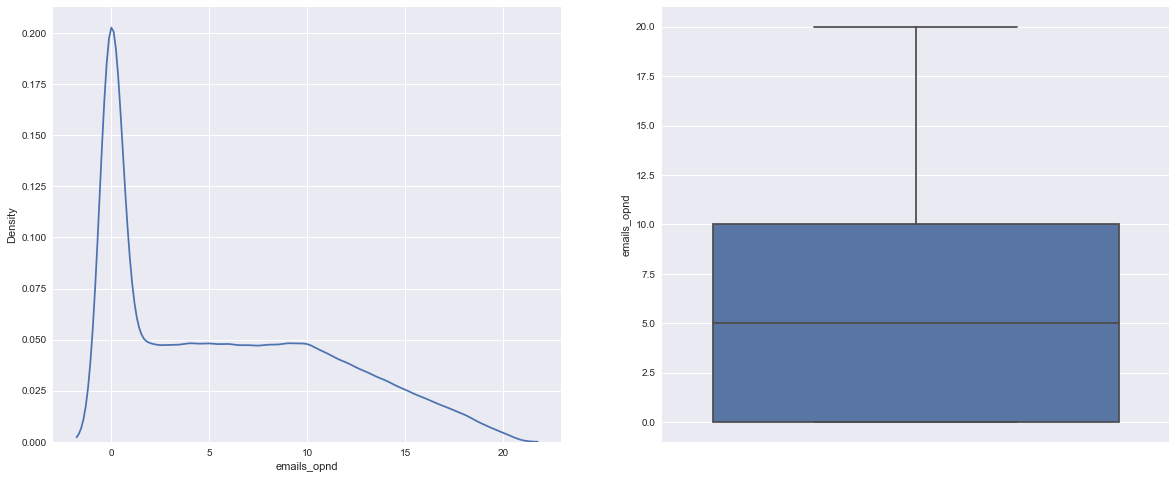

emails_opnd is not normally distributed.

Normality test for faxes_snt
Statitics = 0.935, p value = 0.000


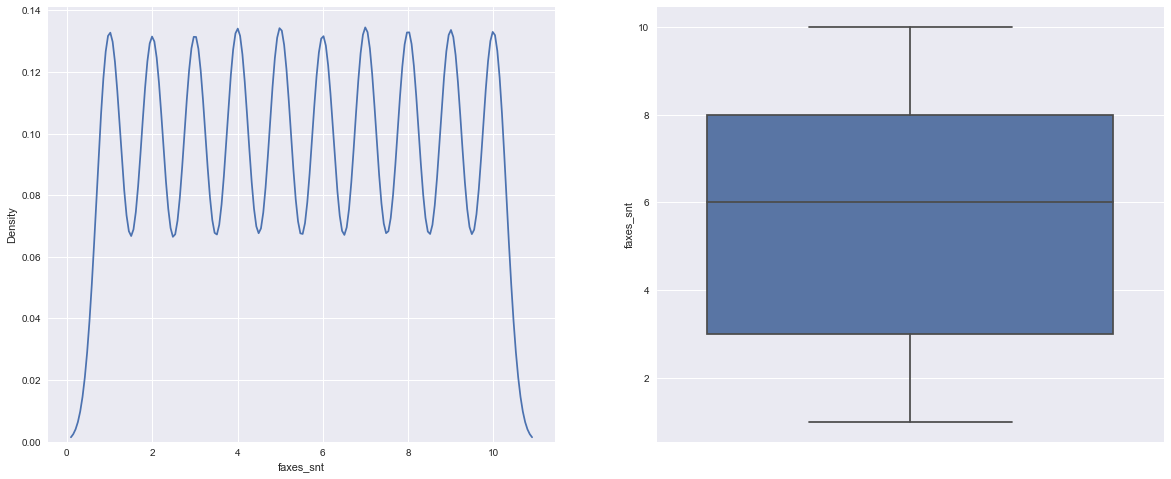

faxes_snt is not normally distributed.

Normality test for brnd_sls
Statitics = nan, p value = 1.000


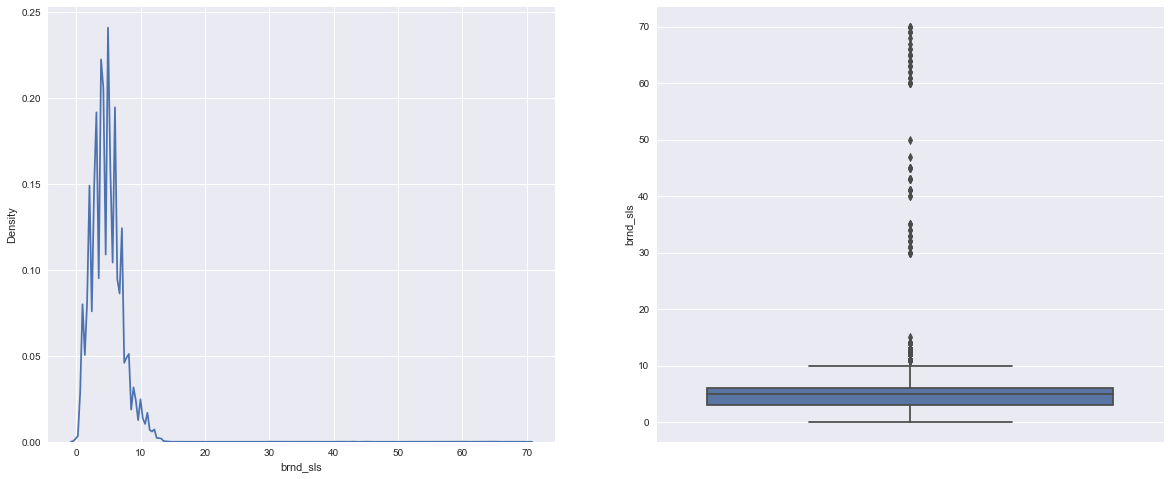

brnd_sls is normally distribution and has Gaussian curve.

Normality test for comp_sls
Statitics = nan, p value = 1.000


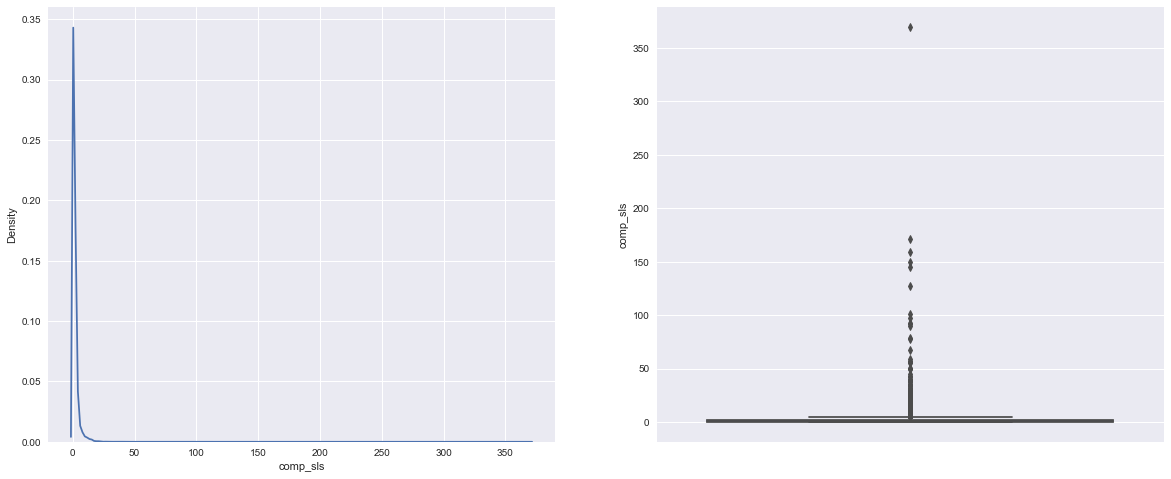

comp_sls is normally distribution and has Gaussian curve.

Normality test for tot_brnded_sls
Statitics = 0.962, p value = 0.000


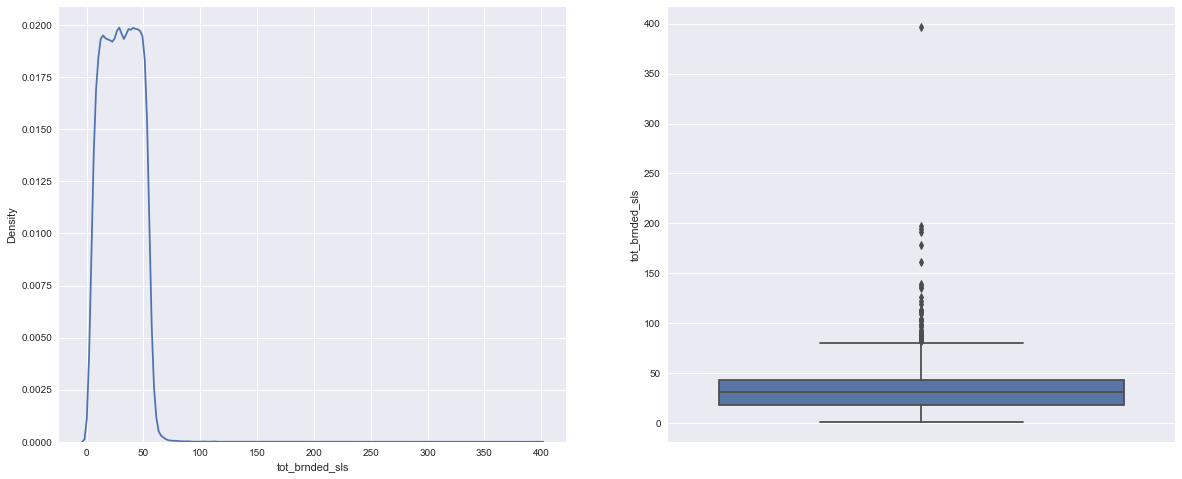

tot_brnded_sls is not normally distributed.

Normality test for tot_mkt_sls
Statitics = 0.646, p value = 0.000


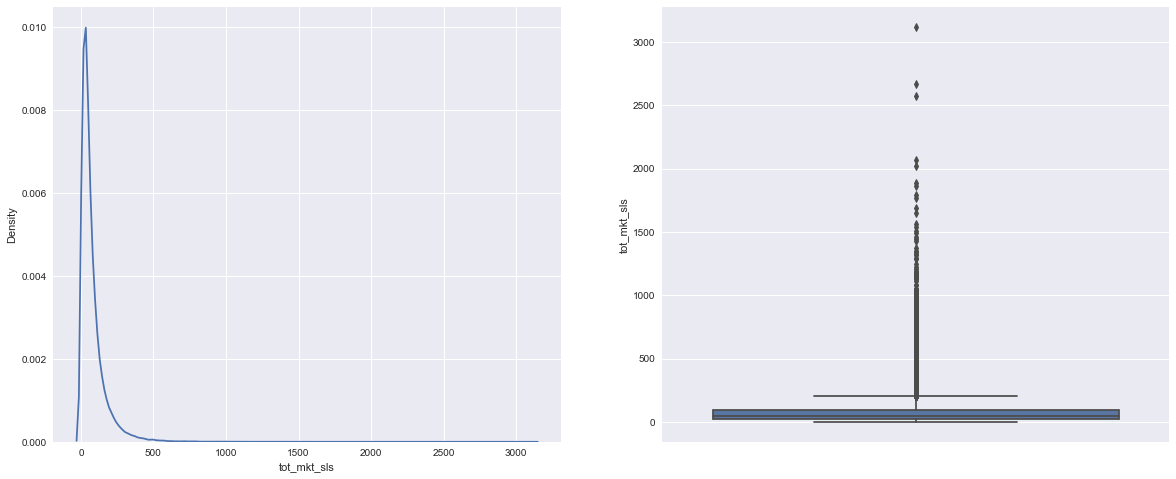

tot_mkt_sls is not normally distributed.



In [121]:
from scipy.stats import shapiro as shapiro

for feature in rd_cont.columns:
    stats, p_val = shapiro(rd_cont[feature])
    print('Normality test for', feature)
    print('Statitics = %.3f, p value = %.3f' % (stats, p_val))
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.kdeplot(ax=axes[0], x=rd_cont[feature])
    sns.boxplot(ax=axes[1], y=rd_cont[feature])
    plt.show()
    if p_val > 0.05: print(feature, 'is normally distribution and has Gaussian curve.\n')
    else: print(feature, 'is not normally distributed.\n')

In [122]:
rd_cont['brnd_sls'].median()

5.0

In [123]:
df = rd.copy()

In [124]:
df['brnd_sls'].fillna(5, inplace = True)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77641 entries, 0 to 77640
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cust_id         77641 non-null  object 
 1   title           77641 non-null  object 
 2   spec_code       77641 non-null  object 
 3   spec_desc       77641 non-null  object 
 4   st              77641 non-null  object 
 5   reg             76280 non-null  object 
 6   atmptd_calls    77641 non-null  int64  
 7   calls_cmpltd    77641 non-null  int64  
 8   emails_snt      77641 non-null  int64  
 9   emails_opnd     77641 non-null  int64  
 10  faxes_snt       77641 non-null  int64  
 11  brnd_sls        77641 non-null  float64
 12  comp_sls        33846 non-null  float64
 13  tot_brnded_sls  77641 non-null  int64  
 14  tot_mkt_sls     77641 non-null  int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 8.9+ MB


Specialty code has 137 distinct nominal values. It would need some sort of encoding before we can proceed with and model building.

In [126]:
df_cont = df[['atmptd_calls', 'calls_cmpltd','emails_snt', 'emails_opnd', 'faxes_snt','brnd_sls', 'comp_sls','tot_brnded_sls','tot_mkt_sls']]

In [127]:
outlier = []
for x in rd_cont:
    q1, q3 = np.percentile(df_cont[x],[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    for y in df_cont[x]:
        if y<lower_bound:
            outlier.append(df_cont[x])
        elif y>upper_bound:
            outlier.append(df_cont[x])
    #print(outlier)
    print('Percent of outliers for ',x,'is',len(outlier)*100/77641)

Percent of outliers for  atmptd_calls is 0.0
Percent of outliers for  calls_cmpltd is 0.0
Percent of outliers for  emails_snt is 0.0
Percent of outliers for  emails_opnd is 0.0
Percent of outliers for  faxes_snt is 0.0
Percent of outliers for  brnd_sls is 2.0375832356615704
Percent of outliers for  comp_sls is 2.0375832356615704
Percent of outliers for  tot_brnded_sls is 2.095542303679757
Percent of outliers for  tot_mkt_sls is 9.30178642727425


In [128]:
np.percentile(df_cont['brnd_sls'],[25,75])

array([3., 6.])

In [129]:
df[df['reg'].isnull()]['st'].unique()

array(['PR', 'DC', 'AP', 'AE', 'VI'], dtype=object)

In [130]:
df['reg'].replace(to_replace=np.nan,value='US Territory', inplace=True)

In [131]:
df['reg'].unique()

array(['South Region', 'Northeast Region', 'Midwest Region',
       'West Region', 'US Territory'], dtype=object)

In [132]:
df['comp_sls'].replace(to_replace=np.nan,value=0, inplace=True)

### Checkpoint

In [133]:
tot_mkt_sls_new = []
for x in range(0,len(df['tot_mkt_sls'])):
    if df['tot_mkt_sls'].iloc[x]>=df['tot_brnded_sls'].iloc[x]:
        tot_mkt_sls_new.append(df['tot_mkt_sls'].iloc[x])
    else:
        tot_mkt_sls_new.append(df['tot_brnded_sls'].iloc[x])
print(tot_mkt_sls_new)

[131, 56, 161, 180, 44, 36, 298, 31, 217, 227, 43, 151, 33, 42, 255, 31, 19, 27, 247, 201, 49, 45, 28, 160, 18, 380, 72, 58, 173, 21, 25, 36, 163, 53, 143, 28, 247, 125, 78, 367, 45, 208, 146, 111, 376, 31, 39, 286, 22, 56, 279, 269, 50, 47, 43, 70, 55, 80, 43, 27, 83, 145, 823, 309, 93, 101, 49, 122, 40, 97, 282, 96, 62, 54, 111, 130, 55, 46, 43, 40, 66, 65, 66, 48, 160, 250, 59, 36, 49, 123, 78, 42, 143, 65, 63, 51, 157, 57, 53, 61, 31, 131, 173, 90, 44, 29, 60, 272, 62, 54, 33, 25, 45, 25, 33, 29, 80, 62, 43, 226, 57, 42, 50, 5, 255, 54, 108, 53, 18, 38, 76, 32, 95, 258, 234, 54, 12, 38, 43, 48, 182, 46, 40, 47, 45, 52, 74, 104, 50, 96, 9, 40, 35, 60, 58, 424, 95, 105, 36, 137, 39, 86, 139, 229, 59, 57, 221, 96, 68, 27, 109, 360, 58, 34, 139, 96, 33, 909, 51, 54, 42, 38, 53, 105, 36, 28, 161, 76, 38, 74, 139, 65, 49, 25, 66, 28, 240, 98, 115, 43, 88, 224, 39, 183, 131, 49, 92, 261, 118, 251, 41, 54, 105, 294, 4, 39, 80, 205, 406, 27, 1155, 110, 73, 117, 17, 22, 27, 94, 31, 78, 111, 

In [134]:
df['tot_mkt_sls_new'] = tot_mkt_sls_new

In [135]:
# check if total branded sales is greater than total market sales which includes both branded and unbranded sales
print(df[np.where(df['tot_brnded_sls']>df['tot_mkt_sls'],True,False)].shape[0]*100/77641)

29.900439200937647


In [136]:
# check if total branded sales is greater than total market sales which includes both branded and unbranded sales
print(df[np.where(df['tot_brnded_sls']>df['tot_mkt_sls_new'],True,False)].shape[0]*100/77641)

0.0


In [137]:
spec_grp = pd.read_csv('../data/spec_grp_lkp.csv',sep='\t'); spec_grp.head()

,spec_code,spec_grp
0,A,ALLERGY/IMMUNOLOGY
1,ADL,PEDIATRICS
2,ADM,OTHER
3,ADP,PSYCHIATRY
4,AHF,INTERNAL MEDICINE


In [138]:
df_v2 = pd.merge(df, spec_grp, on='spec_code')

In [139]:
df_v2['tot_comp_sls'] = df_v2['tot_brnded_sls'] - df_v2['brnd_sls']

In [140]:
df_v2.head()

,cust_id,title,spec_code,spec_desc,st,reg,atmptd_calls,calls_cmpltd,emails_snt,emails_opnd,faxes_snt,brnd_sls,comp_sls,tot_brnded_sls,tot_mkt_sls,tot_mkt_sls_new,spec_grp,tot_comp_sls
0,IND000001,MD,FM,FAMILY MEDICINE,SC,South Region,1,0,13,6,8,8.0,0.0,27,131,131,FAMILY/GENERAL PRACTICE,19.0
1,IND000004,MD,FM,FAMILY MEDICINE,AL,South Region,0,0,11,9,8,9.0,0.0,39,180,180,FAMILY/GENERAL PRACTICE,30.0
2,IND000008,MD,FM,FAMILY MEDICINE,TX,South Region,2,0,1,0,9,1.0,2.0,29,31,31,FAMILY/GENERAL PRACTICE,28.0
3,IND000009,MD,FM,FAMILY MEDICINE,LA,South Region,4,2,4,3,10,11.0,0.0,38,217,217,FAMILY/GENERAL PRACTICE,27.0
4,IND000011,MD,FM,FAMILY MEDICINE,AL,South Region,4,2,10,1,1,2.0,0.0,43,4,43,FAMILY/GENERAL PRACTICE,41.0


In [141]:
df_v3 = df_v2.copy()

In [142]:
df_v3.drop({'cust_id','title','spec_code','spec_desc','st','comp_sls','tot_mkt_sls'},axis=1,inplace=True); df_v3.head()

,reg,atmptd_calls,calls_cmpltd,emails_snt,emails_opnd,faxes_snt,brnd_sls,tot_brnded_sls,tot_mkt_sls_new,spec_grp,tot_comp_sls
0,South Region,1,0,13,6,8,8.0,27,131,FAMILY/GENERAL PRACTICE,19.0
1,South Region,0,0,11,9,8,9.0,39,180,FAMILY/GENERAL PRACTICE,30.0
2,South Region,2,0,1,0,9,1.0,29,31,FAMILY/GENERAL PRACTICE,28.0
3,South Region,4,2,4,3,10,11.0,38,217,FAMILY/GENERAL PRACTICE,27.0
4,South Region,4,2,10,1,1,2.0,43,43,FAMILY/GENERAL PRACTICE,41.0


In [143]:
df_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77641 entries, 0 to 77640
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reg              77641 non-null  object 
 1   atmptd_calls     77641 non-null  int64  
 2   calls_cmpltd     77641 non-null  int64  
 3   emails_snt       77641 non-null  int64  
 4   emails_opnd      77641 non-null  int64  
 5   faxes_snt        77641 non-null  int64  
 6   brnd_sls         77641 non-null  float64
 7   tot_brnded_sls   77641 non-null  int64  
 8   tot_mkt_sls_new  77641 non-null  int64  
 9   spec_grp         77641 non-null  object 
 10  tot_comp_sls     77641 non-null  float64
dtypes: float64(2), int64(7), object(2)
memory usage: 7.1+ MB


In [144]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [145]:
df_final = reduce_mem_usage(df_v3)

Memory usage of dataframe is 7.11 MB --> 3.04 MB (Decreased by 57.3%)


In [146]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77641 entries, 0 to 77640
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reg              77641 non-null  object 
 1   atmptd_calls     77641 non-null  int8   
 2   calls_cmpltd     77641 non-null  int8   
 3   emails_snt       77641 non-null  int8   
 4   emails_opnd      77641 non-null  int8   
 5   faxes_snt        77641 non-null  int8   
 6   brnd_sls         77641 non-null  float32
 7   tot_brnded_sls   77641 non-null  int16  
 8   tot_mkt_sls_new  77641 non-null  int16  
 9   spec_grp         77641 non-null  object 
 10  tot_comp_sls     77641 non-null  float32
dtypes: float32(2), int16(2), int8(5), object(2)
memory usage: 3.0+ MB


In [147]:
df_final.shape

(77641, 11)

In [148]:
df_final.columns

Index(['reg', 'atmptd_calls', 'calls_cmpltd', 'emails_snt', 'emails_opnd',
       'faxes_snt', 'brnd_sls', 'tot_brnded_sls', 'tot_mkt_sls_new',
       'spec_grp', 'tot_comp_sls'],
      dtype='object')

<AxesSubplot:xlabel='reg', ylabel='brnd_sls'>

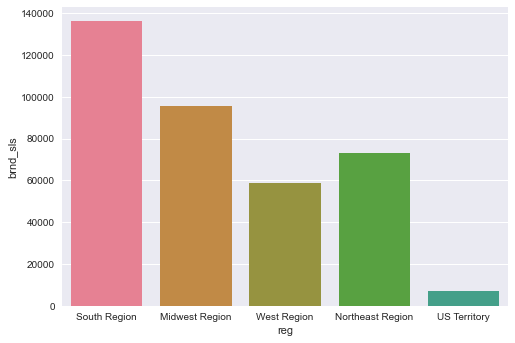

In [157]:
sns.barplot(df_final['reg'],df_final['brnd_sls'],ci=False,estimator=sum,order=df_final['brnd_sls'])

In [ ]:
sns.barplot(df_final['brnd_sls'],df_final['spec_grp'],ci=False,estimator=sum, order=df_final['brnd_sls'])

<AxesSubplot:xlabel='brnd_sls', ylabel='spec_grp'>